In [1]:
import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from vcs2425 import ApplyColormap, train, evaluate, evaluate_topk, plot_training_curves, load_dataset_splits
import time

# 1. Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
COLOR_MAP = 'stacked'

# 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((224, 224)),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
# 4. Load full dataset
train_dataset, val_dataset = load_dataset_splits('../../ILSVRC2012_depth', train_transform, val_transform)

BATCH_SIZE = 128

# 7. DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)

# Training


We are going to train only the classifier

In [4]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False
    
for param in model.fc.parameters():
    param.requires_grad = True

# Unfreeze the last convolutional block (layer4 in ResNet50)
for param in model.layer4.parameters():
    param.requires_grad = True

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# Print the number of trainable and frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

Total parameters: 25,557,032
Trainable parameters: 17,013,736
Frozen parameters: 8,543,296


# Fine Tuning Classifier


In [6]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-4
REDUCE_LR_PATIENCE = 3
REDUCE_LR_FACTOR = 0.5

# 9. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam([
    {'params': model.fc.parameters(), 'lr': LEARNING_RATE },
    {'params': model.layer4.parameters(), 'lr': LEARNING_RATE},
], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE)

In [7]:
NUM_EPOCHS = 30
MODEL_NAME = 'resnet50_pft'

train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []


for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_accuracy = train(model, 
        loader=train_loader, 
        criterion=criterion, 
        optimizer=optimizer,
        device=device,
        model_name=MODEL_NAME)

    train_time = time.time()

    eval_loss, eval_accuracy = evaluate(model, 
                                        loader=val_loader, 
                                        device=device,
                                        criterion=criterion)
    
    scheduler.step(eval_loss)
    
    eval_time = time.time()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} Time: {(eval_time-start_time):.2f}s - \n"
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Took {(train_time-start_time):.2f}s, \n"
          f"Val Loss: {eval_loss:.4f}, Val Accuracy: {eval_accuracy:.4f}, Took {(eval_time-train_time):.2f}s \n")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)

print("Training Complete!")

Epoch 1/30 Time: 77.26s - 
Train Loss: 4.5372, Train Accuracy: 0.1563, Took 65.58s, 
Val Loss: 3.8294, Val Accuracy: 0.2286, Took 11.68s 



Epoch 2/30 Time: 69.91s - 
Train Loss: 3.6417, Train Accuracy: 0.2525, Took 58.52s, 
Val Loss: 3.5376, Val Accuracy: 0.2690, Took 11.39s 



Epoch 3/30 Time: 71.32s - 
Train Loss: 3.2675, Train Accuracy: 0.3071, Took 59.99s, 
Val Loss: 3.4133, Val Accuracy: 0.2827, Took 11.34s 



Epoch 4/30 Time: 70.28s - 
Train Loss: 3.0076, Train Accuracy: 0.3474, Took 58.92s, 
Val Loss: 3.3405, Val Accuracy: 0.2900, Took 11.36s 



Epoch 5/30 Time: 69.72s - 
Train Loss: 2.7886, Train Accuracy: 0.3832, Took 58.39s, 
Val Loss: 3.3078, Val Accuracy: 0.3021, Took 11.33s 



Epoch 6/30 Time: 70.55s - 
Train Loss: 2.5105, Train Accuracy: 0.4421, Took 59.20s, 
Val Loss: 3.2460, Val Accuracy: 0.3090, Took 11.35s 



Epoch 7/30 Time: 70.31s - 
Train Loss: 2.3932, Train Accuracy: 0.4633, Took 59.02s, 
Val Loss: 3.2297, Val Accuracy: 0.3145, Took 11.29s 



Epoch 8/30 Time: 70.90s - 
Train Loss: 2.3007, Train Accuracy: 0.4830, Took 59.47s, 
Val Loss: 3.2105, Val Accuracy: 0.3156, Took 11.43s 



Epoch 9/30 Time: 67.72s - 
Train Loss: 2.2021, Train Accuracy: 0.5029, Took 57.18s, 
Val Loss: 3.2027, Val Accuracy: 0.3196, Took 10.54s 



Epoch 10/30 Time: 65.46s - 
Train Loss: 2.0703, Train Accuracy: 0.5348, Took 54.85s, 
Val Loss: 3.1872, Val Accuracy: 0.3198, Took 10.61s 



Epoch 11/30 Time: 65.52s - 
Train Loss: 2.0229, Train Accuracy: 0.5455, Took 54.93s, 
Val Loss: 3.1874, Val Accuracy: 0.3202, Took 10.59s 



Epoch 12/30 Time: 65.67s - 
Train Loss: 1.9732, Train Accuracy: 0.5569, Took 55.06s, 
Val Loss: 3.1876, Val Accuracy: 0.3246, Took 10.60s 



Epoch 13/30 Time: 65.28s - 
Train Loss: 1.9310, Train Accuracy: 0.5642, Took 54.69s, 
Val Loss: 3.1842, Val Accuracy: 0.3228, Took 10.59s 



Epoch 14/30 Time: 65.62s - 
Train Loss: 1.8558, Train Accuracy: 0.5853, Took 54.23s, 
Val Loss: 3.1756, Val Accuracy: 0.3252, Took 11.38s 



Epoch 15/30 Time: 70.91s - 
Train Loss: 1.8371, Train Accuracy: 0.5884, Took 59.46s, 
Val Loss: 3.1797, Val Accuracy: 0.3259, Took 11.44s 



Epoch 16/30 Time: 71.42s - 
Train Loss: 1.8062, Train Accuracy: 0.5952, Took 59.80s, 
Val Loss: 3.1788, Val Accuracy: 0.3267, Took 11.62s 



Epoch 17/30 Time: 71.28s - 
Train Loss: 1.7880, Train Accuracy: 0.6006, Took 59.85s, 
Val Loss: 3.1779, Val Accuracy: 0.3245, Took 11.44s 



Epoch 18/30 Time: 71.23s - 
Train Loss: 1.7542, Train Accuracy: 0.6106, Took 59.82s, 
Val Loss: 3.1775, Val Accuracy: 0.3259, Took 11.41s 



Epoch 19/30 Time: 71.07s - 
Train Loss: 1.7432, Train Accuracy: 0.6075, Took 59.60s, 
Val Loss: 3.1771, Val Accuracy: 0.3257, Took 11.46s 



Epoch 20/30 Time: 71.11s - 
Train Loss: 1.7299, Train Accuracy: 0.6144, Took 59.65s, 
Val Loss: 3.1801, Val Accuracy: 0.3249, Took 11.46s 



Epoch 21/30 Time: 70.22s - 
Train Loss: 1.7139, Train Accuracy: 0.6182, Took 58.57s, 
Val Loss: 3.1780, Val Accuracy: 0.3266, Took 11.65s 



Epoch 22/30 Time: 66.59s - 
Train Loss: 1.7018, Train Accuracy: 0.6198, Took 56.04s, 
Val Loss: 3.1707, Val Accuracy: 0.3267, Took 10.55s 



Epoch 23/30 Time: 66.05s - 
Train Loss: 1.6996, Train Accuracy: 0.6208, Took 55.44s, 
Val Loss: 3.1807, Val Accuracy: 0.3256, Took 10.61s 



Epoch 24/30 Time: 65.46s - 
Train Loss: 1.6838, Train Accuracy: 0.6231, Took 54.88s, 
Val Loss: 3.1825, Val Accuracy: 0.3261, Took 10.57s 



Epoch 25/30 Time: 65.31s - 
Train Loss: 1.6825, Train Accuracy: 0.6246, Took 54.76s, 
Val Loss: 3.1806, Val Accuracy: 0.3223, Took 10.55s 



Epoch 26/30 Time: 66.06s - 
Train Loss: 1.6740, Train Accuracy: 0.6278, Took 55.45s, 
Val Loss: 3.1826, Val Accuracy: 0.3259, Took 10.61s 



Epoch 27/30 Time: 66.03s - 
Train Loss: 1.6699, Train Accuracy: 0.6298, Took 55.41s, 
Val Loss: 3.1835, Val Accuracy: 0.3254, Took 10.61s 



Epoch 28/30 Time: 65.98s - 
Train Loss: 1.6702, Train Accuracy: 0.6298, Took 55.40s, 
Val Loss: 3.1735, Val Accuracy: 0.3246, Took 10.58s 



Epoch 29/30 Time: 65.04s - 
Train Loss: 1.6671, Train Accuracy: 0.6294, Took 54.40s, 
Val Loss: 3.1741, Val Accuracy: 0.3267, Took 10.64s 



Epoch 30/30 Time: 65.09s - 
Train Loss: 1.6621, Train Accuracy: 0.6297, Took 54.53s, 
Val Loss: 3.1780, Val Accuracy: 0.3255, Took 10.56s 

Training Complete!


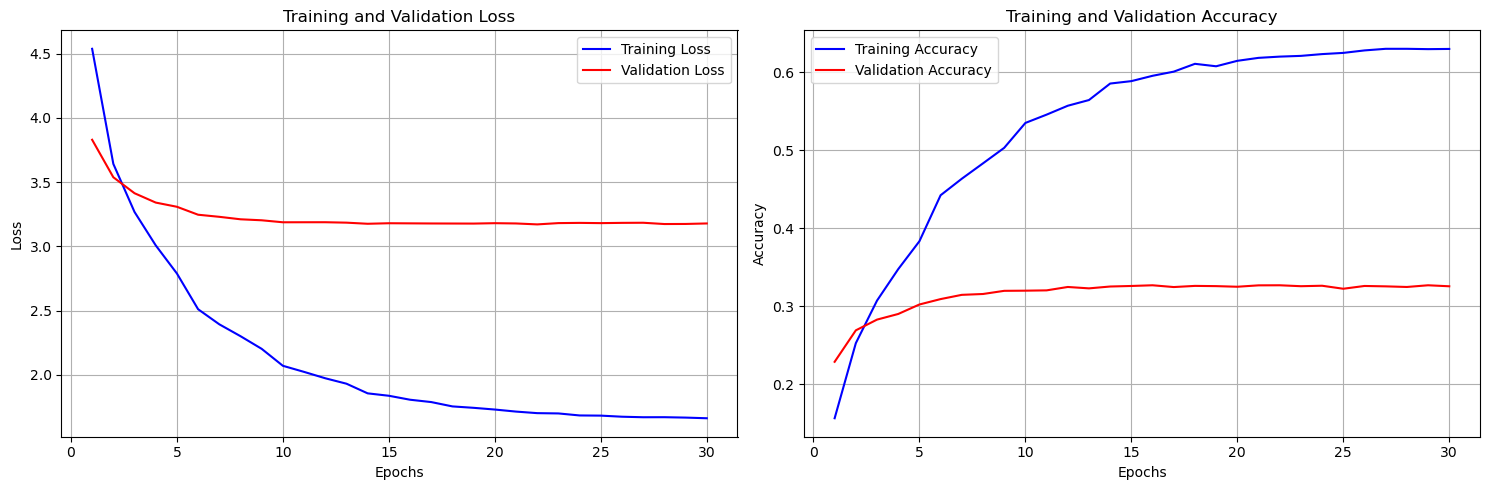

In [8]:
plot_training_curves(
    (train_losses, train_accuracies),
    (eval_losses, eval_accuracies),
)

# Evaluation metrics

In [9]:
# Load the best model weights
best_model_path = f"{MODEL_NAME}.pth"

# Load the saved model weights
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set the model to evaluation mode
print(f"Loaded best model from {best_model_path}")

# Evaluate the loaded model
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device=device)
print(f"Best model - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Loaded best model from resnet50_pft.pth


Best model - Validation Loss: 3.1787, Validation Accuracy: 0.3235


In [10]:
top_1 = evaluate_topk(model, val_loader, k=1, device=device)
top_5 = evaluate_topk(model, val_loader, k=5, device=device)

print(f"Colormap: {COLOR_MAP}, Top-1 Accuracy: {top_1:.4f}, Top-5 Accuracy: {top_5:.4f}")

Colormap: stacked, Top-1 Accuracy: 0.3236, Top-5 Accuracy: 0.5787
